In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
import re
from collections import Counter
import random

import tensorflow as tf
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [2]:
TRAIN_FP = '../input/nlp-getting-started/train.csv'
TEST_FP = '../input/nlp-getting-started/test.csv'

train = pd.read_csv(TRAIN_FP)
test = pd.read_csv(TEST_FP)

In [3]:
disaster_tweets = train.loc[train['target'] == 1, :].shape[0]
total_tweets = train.shape[0]
print(f'{disaster_tweets} disasters, {(disaster_tweets/total_tweets)*100:.2f}% of training set')

3271 disasters, 42.97% of training set


In [4]:
train_duplicates = train.loc[train.duplicated(subset='text', keep=False), :]
num_unique_duplicated_tweets = train_duplicates.loc(axis=1)['text'].unique().shape[0]
num_total_duplicated_tweets = train_duplicates.shape[0]

print(f'{num_unique_duplicated_tweets} tweets duplicated, {num_total_duplicated_tweets} total duplicates')

69 tweets duplicated, 179 total duplicates


In [5]:
# For the duplicated entries, if not marked the same => drop altogether
duplicated_tweets = train_duplicates.loc(axis=1)['text'].unique()
train_first_of_duplicate = pd.DataFrame(columns=train.columns)

for tweet in duplicated_tweets:
    if train_duplicates.loc(axis=0)[train_duplicates['text'] == tweet]['target'].unique().shape[0] == 1:
        train_first_of_duplicate = pd.concat([
            train_first_of_duplicate,
            pd.DataFrame(train_duplicates.loc(axis=0)[train_duplicates['text'] == tweet].iloc[0]).T
        ],
            ignore_index=True
        )

# All of training set with none of the duplicates
train_unduplicated = train.drop_duplicates(subset='text', keep=False)

# All of training set with first instance of each duplicate included
train_all_no_duplicates = pd.concat([
    train_first_of_duplicate,
    train_unduplicated     
],
    ignore_index=True
)

# Check no duplicates remain
remaining_duplicates = train_all_no_duplicates.loc[train_all_no_duplicates.duplicated(subset='text', keep=False), :]
print(f'Remaining duplicates in training set: {remaining_duplicates.shape[0]}')

Remaining duplicates in training set: 0


In [6]:
train_set = train_all_no_duplicates
test_set = test

### Pre-Processing

In [7]:
# Clean up tweet content

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess_text(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}', "") 
    rem_url = re.sub(r'http\S+', '', sentence)
    cleanr = re.compile('[^A-Za-z ]+')
    rem_num_non_alpha = re.sub(cleanr, '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num_non_alpha)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)

train_set['clean_text'] = train_set['text'].map(lambda s:preprocess_text(s))

In [8]:
# Create vocab list and word index

vocab = []
for i in range(train_set.shape[0]):
    vocab.extend(train_set.loc(axis=1)['clean_text'].iloc(axis=0)[i].split(" "))
    
vocab_counter = Counter(vocab)
word_index = {word:index for index, word in enumerate(map(lambda v: v[0], vocab_counter.most_common()), 2)}
word_index['<OOV>'] = 1
vocab_size = max(word_index.values()) + 1

In [9]:
SEQ_LENGTH = 20

def words_to_integer_sequence(sequence, word_index):
    sequence_integer_vector = np.zeros([SEQ_LENGTH])
    for i, word in enumerate(sequence):
        if i < SEQ_LENGTH:
            sequence_integer_vector[i] = word_index[word] if word in word_index else 1
    
    return sequence_integer_vector

def integer_to_words_sequence(sequence, word_index):
    index_list = list(word_index.values())
    word_list = list(word_index.keys())
    word_sequence = []
    for i in sequence:
        if i > 0:
            word_loc = index_list.index(i)
            word_sequence.append(word_list[word_loc])
    
    return word_sequence
        

In [10]:
X = []

for i in range(train_set.shape[0]):
    sequence_tokenized = train_set['clean_text'].iloc(axis=0)[i].split(" ")
    integer_vector = words_to_integer_sequence(sequence_tokenized, word_index)
    X.append(integer_vector)

y = train_set.loc(axis=1)['target'].astype('int').to_list()

X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f'Training Set X: {X_train.shape}, y: {y_train.shape}')
print(f'Validation Set X: {X_val.shape}, y: {y_val.shape}')

Training Set X: (6736, 20), y: (6736,)
Validation Set X: (749, 20), y: (749,)


In [11]:
example_num = random.randint(0, y_train.shape[0])
print(X_train[example_num])
print(integer_to_words_sequence(X_train[example_num], word_index))
print(y_train[example_num])

[3.4700e+02 5.3000e+01 1.7600e+02 8.5000e+01 1.3647e+04 3.4520e+03
 3.6700e+02 4.7300e+02 2.9600e+02 5.4200e+02 4.8200e+02 4.8160e+03
 1.3000e+01 1.1000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
['group', 'suicid', 'bomber', 'deton', 'explosivespack', 'vest', 'mosqu', 'insid', 'saudi', 'special', 'forc', 'headquart', 'kill', 'peopl']
1


### Validation Model

In [12]:
vocab_size = max(word_index.values()) + 1
embedding_dim = 8
gru_dim = 8

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=SEQ_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-08-10 08:52:43.989765: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             109232    
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                864       
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 110,169
Trainable params: 110,169
Non-trainable params: 0
_________________________________________________________________


In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('disaster_dense.h5', monitor='val_loss', mode='min', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

callback = [checkpoint, early_stopping]

In [14]:
NUM_EPOCHS = 100
BATCH_SIZE = 16

history = model.fit(
    X_train, y_train, batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS, validation_data=(X_val, y_val),
    callbacks=callback
)

Epoch 1/100


2022-08-10 08:52:44.641592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


421/421 [==============================] - 9s 14ms/step - loss: 0.5762 - accuracy: 0.6951 - val_loss: 0.4295 - val_accuracy: 0.8117
Epoch 2/100
421/421 [==============================] - 6s 14ms/step - loss: 0.3325 - accuracy: 0.8643 - val_loss: 0.4188 - val_accuracy: 0.8304
Epoch 3/100
421/421 [==============================] - 5s 13ms/step - loss: 0.2078 - accuracy: 0.9222 - val_loss: 0.4692 - val_accuracy: 0.8291
Epoch 4/100
421/421 [==============================] - 5s 12ms/step - loss: 0.1360 - accuracy: 0.9537 - val_loss: 0.5521 - val_accuracy: 0.8104
Epoch 5/100
421/421 [==============================] - 5s 12ms/step - loss: 0.0960 - accuracy: 0.9687 - val_loss: 0.6271 - val_accuracy: 0.7770
Epoch 6/100
421/421 [==============================] - 5s 12ms/step - loss: 0.0732 - accuracy: 0.9758 - val_loss: 0.6870 - val_accuracy: 0.7984
Epoch 7/100
421/421 [==============================] - 5s 12ms/step - loss: 0.0683 - accuracy: 0.9761 - val_loss: 0.7032 - val_accuracy: 0.7757
Epoc

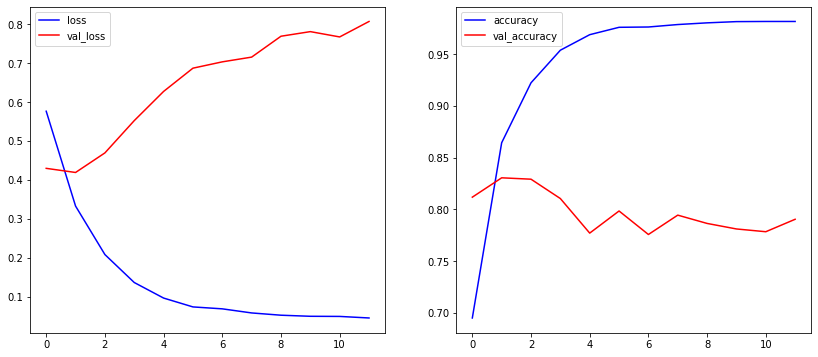

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
axs[0].plot(history.history['loss'], color='blue')
axs[0].plot(history.history['val_loss'], color='red')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.history['accuracy'], color='blue')
axs[1].plot(history.history['val_accuracy'], color='red')
axs[1].legend(['accuracy', 'val_accuracy'])

### Test Model

In [16]:
test_set['clean_text'] = test_set['text'].map(lambda s:preprocess_text(s))

X_test = []

for i in range(test_set.shape[0]):
    sequence_tokenized = test_set['clean_text'].iloc(axis=0)[i].split(" ")
    integer_vector = words_to_integer_sequence(sequence_tokenized, word_index)
    X_test.append(integer_vector)

X_test = np.array(X_test)
test_ids = test.loc(axis=1)['id']

In [17]:
y_test_pred = pd.DataFrame(data=test_ids, columns=['id'])
y_test_pred['target'] = np.round(model.predict(X_test)).astype('int')
y_test_pred.to_csv('./submission.csv', index=False)
y_test_pred.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
3262,10875,1
